In [3]:
import pymc as pm
import arviz as az

from scipy.stats import beta, gamma, norm, cauchy
from scipy import io as sio
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, ttest_rel, ttest_ind
from scipy.optimize import minimize
from pytensor import tensor as pt 

## 17.1 The GCM Model

泛化情景模型GCM（generalized context model）是用来解释个体如何完成分类决策任务的
- 刺激作为样例exemplars被存储
- 不同的刺激维度上有不同的指标，对应高维心理空间上的坐标
- 因为选择性注意，被试对不同刺激维度注意的程度是不同的
- 在当前刺激与样例之间进行相似性判断，之后进行决策

Kruschke（1993）的任务：
- 40名被试，观看8个刺激各8次，$y_{ik}$ 记录了被试i将刺激k归类为A的次数（0-8）

GCM模型的参数和假设
- 对每个刺激，有Position和Height两个维度，表示为 $(p_{i1}, p{i2})$;
- 对于两个维度关注权重为 $\omega$ 和 $1-\omega$；
- 两个刺激的距离：$d_{ij} = \omega|p_{i1} - p{j1}| + (1-\omega)|p_{i2} - p_{j2}|$
- 相似性（0不同-1一样）：$s_{ij} = \exp(-cd_{ij})$, $c$ 是泛化能力参数
- 将i归属于A的能力 $\propto \sum_{j\in A} s_{ij}$



In [140]:
mydata = sio.loadmat('data/KruschkeData.mat')
nstim, nsubj = 8, 40
a = 2 - mydata['a'][0] # 真实的类别
y_obs = mydata['y'][:, 0] # 所有被试总共分类到A的次数
d1 = mydata['d1'] # 在position维度上的距离
d2 = mydata['d2'] # 在height维度上的距离
x_obs = mydata['x'] # 逐个被试的结果

y_obs

array([245, 218, 255, 126, 182,  71, 102,  65], dtype=uint8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, w]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 30 seconds.


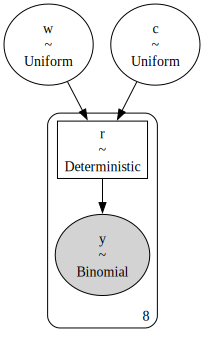

In [25]:
with pm.Model() as GCM1:
    c = pm.Uniform('c', lower = 0, upper = 5)
    w = pm.Uniform('w', lower = 0, upper = 1)
    b = 0.5
    sij = pt.exp(-c * (w * d1 + (1 - w) * d2))
    siA = pt.matmul(sij, a)
    siB = pt.matmul(sij, 1 - a)
    r = pm.Deterministic('r', (b * siA)/(b * siA + (1-b) * siB))
    y = pm.Binomial('y', n = nstim * nsubj, p = r, observed = y_obs)
    trace = pm.sample(3000)
pm.model_to_graphviz(GCM1)
    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,0.980,0.040,0.901,1.053,0.0,0.0,13143.0,8349.0,1.0
w,0.584,0.029,0.529,0.640,0.0,0.0,12956.0,9060.0,1.0


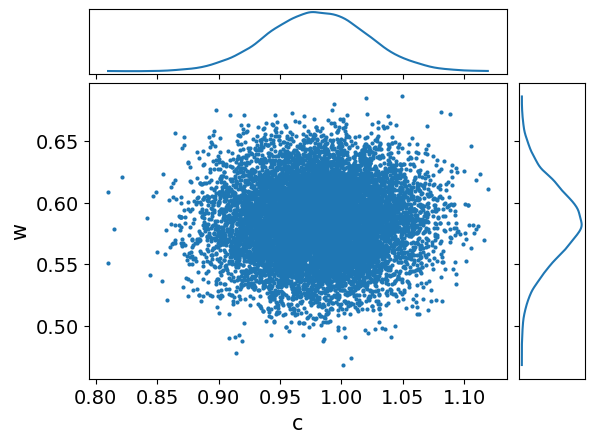

In [29]:
az.plot_pair(trace, var_names = ['c', 'w'], marginals = True)
az.summary(trace, var_names = ['c', 'w'])

In [30]:
# Exercise 17.1.1
# 把b改成U[0,1]对结果基本没有影响
with pm.Model() as GCM1prime:
    c = pm.Uniform('c', lower = 0, upper = 5)
    w = pm.Uniform('w', lower = 0, upper = 1)
    b = pm.Uniform('b', lower = 0, upper = 1)
    sij = pt.exp(-c * (w * d1 + (1 - w) * d2))
    siA = pt.matmul(sij, a)
    siB = pt.matmul(sij, 1 - a)
    r = pm.Deterministic('r', (b * siA)/(b * siA + (1-b) * siB))
    y = pm.Binomial('y', n = nstim * nsubj, p = r, observed = y_obs)
    trace = pm.sample(3000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, w, b]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 26 seconds.


NameError: name 'GCM2' is not defined

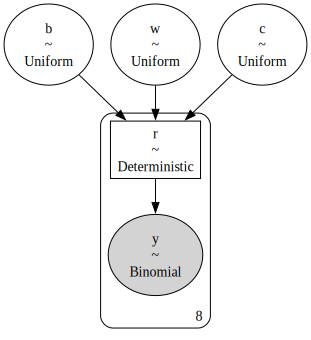

In [31]:
pm.model_to_graphviz(GCM1prime)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.487,0.011,0.467,0.508,0.0,0.0,17810.0,8990.0,1.0
c,0.980,0.040,0.905,1.056,0.0,0.0,17743.0,8936.0,1.0
w,0.584,0.029,0.528,0.637,0.0,0.0,19775.0,9127.0,1.0


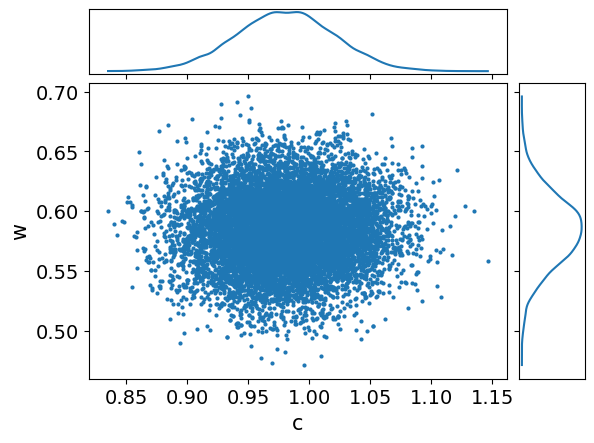

In [32]:
az.plot_pair(trace, var_names = ['c', 'w'], marginals = True)
az.summary(trace, var_names = ['b', 'c', 'w'])

In [63]:
# Exercise 17.1.2
with GCM1:
    post_pred = pm.sample_posterior_predictive(trace)


Sampling: [y]


Output()

In [64]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

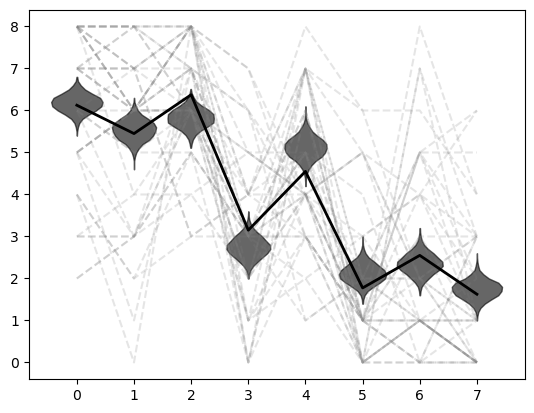

In [77]:
posterior = post_pred.posterior_predictive['y'].values[0]
for i in range(8):
    kde = gaussian_kde(posterior[:, i]/40)
    y_range = np.arange(0, 8, 0.1)
    density = kde(y_range)
    density = density * 0.25
    plt.fill_betweenx(y_range, i - density, i + density,where=(density > 0.001), color = 'black', alpha = 0.6)
plt.plot(x.T, color = 'grey', alpha = 0.2, linestyle = 'dashed')
plt.plot(x.mean(0), color = 'black', linewidth = 2)

## 17.2 Individual difference in the GCM

对每个被试独立的推断一组GCM参数

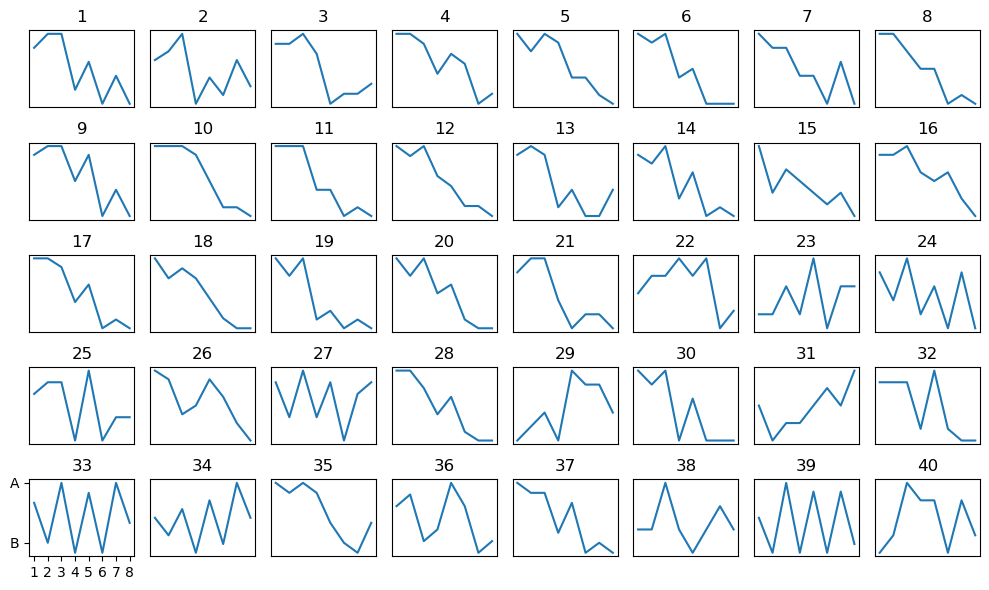

In [95]:
fig, axes = plt.subplots(5, 8, figsize = (10, 6))
axes = axes.flatten()
for i in range(x.shape[0]):
    axes[i].plot(x[i])
    axes[i].set_title(i+1)
    if i != 32:
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    else:
        axes[i].set_xticks(np.arange(8))
        axes[i].set_xticklabels(np.arange(1,9))
        axes[i].set_yticks([1, 7])
        axes[i].set_yticklabels(['B', 'A'])
plt.tight_layout()

array([[0.     , 0.     , 1.00005, 1.00005, 1.95205, 1.95205, 3.1131 ,
        3.1131 ],
       [0.     , 0.     , 1.00005, 1.00005, 1.95205, 1.95205, 3.1131 ,
        3.1131 ],
       [1.00005, 1.00005, 0.     , 0.     , 0.952  , 0.952  , 2.11305,
        2.11305],
       [1.00005, 1.00005, 0.     , 0.     , 0.952  , 0.952  , 2.11305,
        2.11305],
       [1.95205, 1.95205, 0.952  , 0.952  , 0.     , 0.     , 1.16105,
        1.16105],
       [1.95205, 1.95205, 0.952  , 0.952  , 0.     , 0.     , 1.16105,
        1.16105],
       [3.1131 , 3.1131 , 2.11305, 2.11305, 1.16105, 1.16105, 0.     ,
        0.     ],
       [3.1131 , 3.1131 , 2.11305, 2.11305, 1.16105, 1.16105, 0.     ,
        0.     ]])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, w]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 42 seconds.


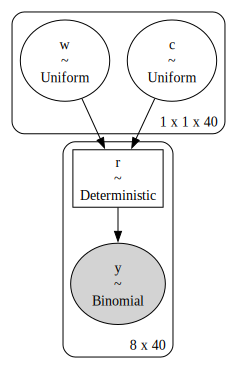

In [137]:
d1_ = np.tile(d1[:, :, np.newaxis], [1, 1, nsubj])
d2_ = np.tile(d2[:, :, np.newaxis], [1, 1, nsubj])
a1 = np.tile(a, [nstim, 1])[:, :, np.newaxis]
with pm.Model() as GCM2:
    c = pm.Uniform('c', lower = 0, upper = 5, shape = (1, 1, nsubj))
    w = pm.Uniform('w', lower = 0, upper = 1, shape = (1, 1, nsubj))
    b = 0.5
    sij = pt.exp(-c * (w * d1_ + (1 - w) * d2_))
    siA = pt.sum(sij * a1, axis = 1)
    siB = pt.sum(sij * (1 - a1), axis = 1)
    r = pm.Deterministic('r', (b * siA)/(b * siA + (1-b) * siB))
    y = pm.Binomial('y', n = nstim, p = r, observed = x.T)
    trace = pm.sample(3000)
pm.model_to_graphviz(GCM2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, w]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


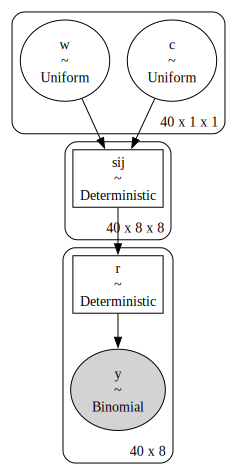

In [166]:
with pm.Model() as GCM2prime:

    c = pm.Uniform('c', lower = 0, upper = 5, shape = (nsubj, 1, 1))  #(nsubj, 1, 1)
    w = pm.Uniform('w', lower = 0, upper = 1, shape = (nsubj, 1, 1))
    b = 0.5

    sijk = pm.Deterministic('sij', pt.exp(-c * (w * d1[None, :, :] + (1 - w) * d2[None, :, :])))  # (nsubj, i, j)
    siA = pt.matmul(sijk, a)
    siB = pt.matmul(sijk, (1 - a))
    r = pm.Deterministic('r', (b * siA)/(b * siA + (1-b) * siB))
    y = pm.Binomial('y', n = nstim, p = r, observed = x_obs)
    trace2 = pm.sample(2000)
pm.model_to_graphviz(GCM2prime)

<ErrorbarContainer object of 3 artists>

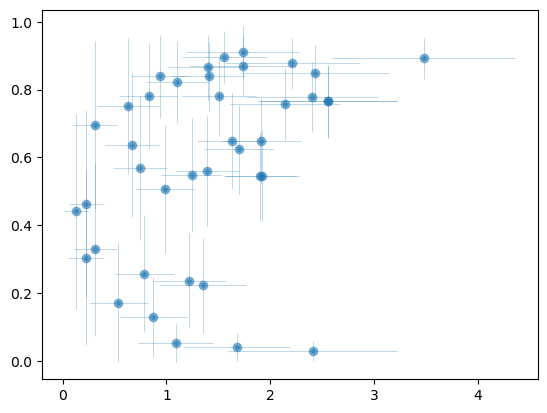

In [198]:
c_values = az.summary(trace2, var_names = ['c'])['mean'].values
c_std = az.summary(trace2, var_names = ['c'])['sd'].values
w_values = az.summary(trace2, var_names = ['w'])['mean'].values
w_std = az.summary(trace2, var_names = ['w'])['sd'].values
plt.scatter(c_values, w_values, alpha = 0.5)
plt.errorbar(x = c_values, y = w_values, fmt = '.', xerr = c_std, yerr = w_std, alpha = 0.5, linewidth = 0.4)

## 17.3 Latent Groups in the GCM

- 31: 很低泛化性c，中等权重w（并且变异性比较大），没有分辨力，用 $r_{ik} = 0.5$ 就可以表征
- 3: 聚焦在location维度，所以会分错4和5
- 33: 聚焦在height维度，所以会分错2和7


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [phic, phig, muw1, muw2, sigmaw, w, muc, sigmac, c]
>BinaryGibbsMetropolis: [zkc, zkg]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 247 seconds.
/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 1013 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


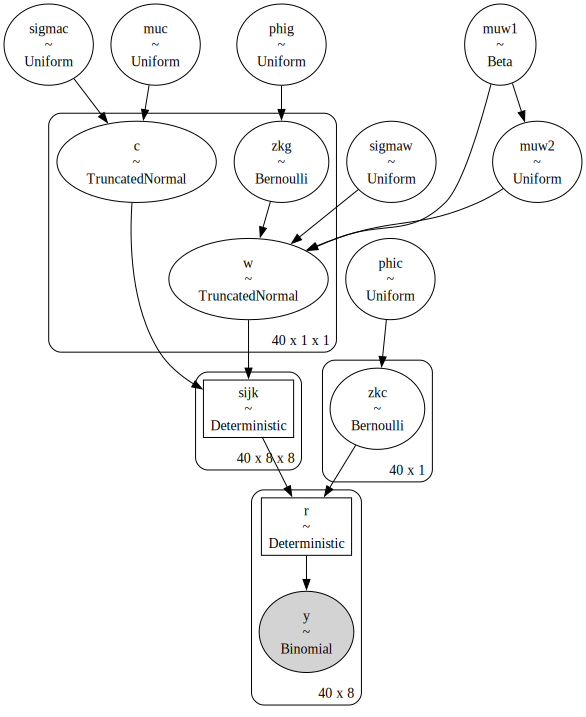

In [209]:
with pm.Model() as GCM3:
    
    phic = pm.Uniform('phic', lower = 0, upper = 1)  
    zkc = pm.Bernoulli('zkc', p = phic, shape = (nsubj, 1)) # 1就是rik=0.5的笨蛋
    phig = pm.Uniform('phig', lower = 0, upper = 1)
    zkg = pm.Bernoulli('zkg', p = phig, shape = (nsubj, 1, 1)) # 1有更高的mu

    muw1 = pm.Beta('muw1', alpha = 2, beta = 1)
    muw2 = pm.Uniform('muw2', lower = 0, upper = muw1)
    sigmaw = pm.Uniform('sigmaw', lower = 0.01, upper = 1)
    w = pm.TruncatedNormal('w', mu = pt.switch(zkg, muw1, muw2), sigma = sigmaw, lower = 0, upper = 1, shape = (nsubj, 1, 1))
    
    muc = pm.Uniform('muc', lower = 0, upper = 5)
    sigmac = pm.Uniform('sigmac', 0.01, 3)
    c = pm.TruncatedNormal('c', mu = muc, sigma = sigmac, lower = 0, upper = 5, shape = (nsubj, 1, 1))

    sijk = pm.Deterministic('sijk', pt.exp(-c * (w * d1[None, :, :] + (1 - w) * d2[None, :, :])))  # (nsubj, i, j)
    siA = pt.matmul(sijk, a)
    siB = pt.matmul(sijk, (1 - a))
    r = pm.Deterministic('r', pt.switch(zkc, np.array([0.5]*nstim), (1 - zkc) * (b * siA)/(b * siA + (1-b) * siB)))
    y = pm.Binomial('y', n = nstim, p = r, observed = x_obs)
    trace_group = pm.sample(2000)
pm.model_to_graphviz(GCM3)


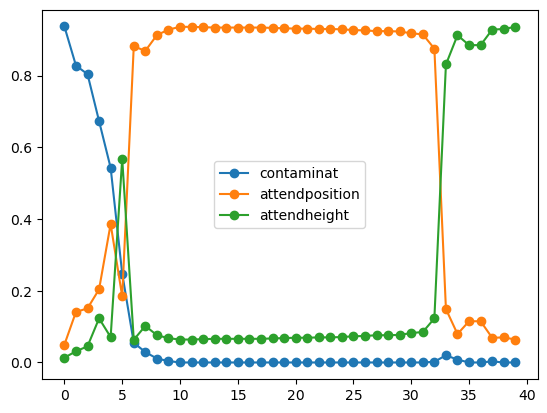

In [264]:
zkc_values = az.summary(trace_group, var_names = ['zkg'], kind = 'stats')['mean'].values
contaminat = az.summary(trace_group, var_names = ['zkc'], kind = 'stats')['mean'].values
attendposition = (1 - contaminat) * zkc_values
attendheight = (1 - contaminat) * (1 - zkc_values)
summ = np.stack([contaminat, attendposition, attendheight], axis = 1)
idx = np.argsort(-attendposition -  5 * contaminat)
plt.plot(summ[idx], '-o')
plt.legend(['contaminat', 'attendposition', 'attendheight'])

In [265]:
with GCM3:
    ppc = pm.sample_posterior_predictive(trace_group)

Sampling: [y]


Output()

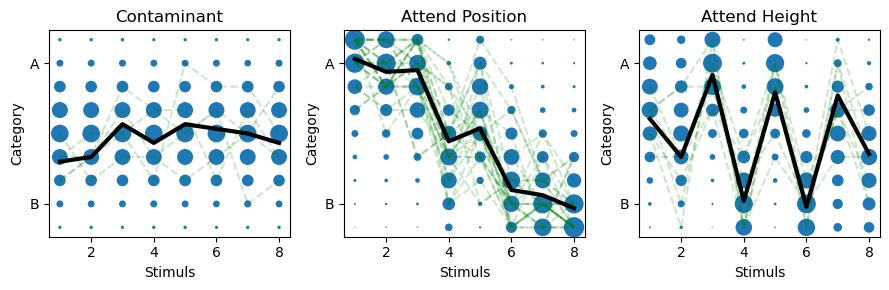

In [351]:
zkc_idx = trace_group.posterior['zkc'].values.reshape(-1)
zkg_idx = trace_group.posterior['zkg'].values.reshape(-1)
y_idx = ppc.posterior_predictive['y'].values.reshape(-1, 8)
identity = np.argmax(summ, axis = 1)

def summary_plot(group, axes):
    if group == 0:
        cond_samp = y_idx[zkc_idx == 1]
    elif group == 1:
        cond_samp = y_idx[(zkc_idx == 0) * (zkg_idx == 1)]
    else:
        cond_samp = y_idx[(zkc_idx == 0) * (zkg_idx == 0)]
    cond_counts = np.apply_along_axis(np.bincount, 0, cond_samp)/cond_samp.shape[0]* 100000
    x, y = np.meshgrid(np.arange(1, 9), np.arange(9))
    axes[group].scatter(x, y, s = cond_counts/200)
    [axes[group].plot(np.arange(1, 9), x, '--g', alpha = 0.2) for x in x_obs[identity == group]]
    axes[group].plot(np.arange(1, 9), x_obs[identity == group].mean(0), '-k', linewidth = 3)
    axes[group].set(xlabel = 'Stimuls', ylabel = 'Category', 
                    title = ['Contaminant', 'Attend Position', 'Attend Height'][group],
                    yticks = [1, 7], yticklabels = ['B', 'A'])

fig, axes = plt.subplots(1, 3, figsize = (9, 3))
[summary_plot(i, axes) for i in range(3)]
plt.tight_layout()

<Axes: title={'center': 'phic'}>

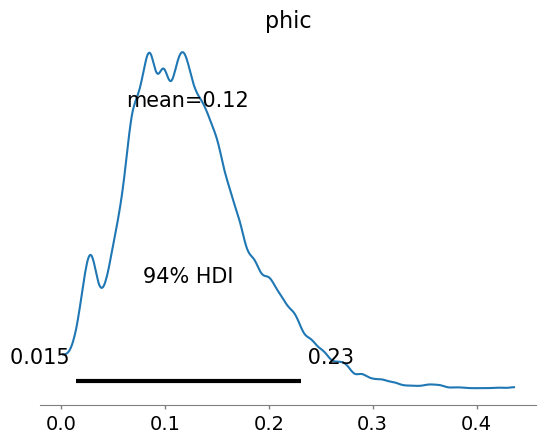

In [352]:
# Exercise 17.3.1 
## 直接就可以画出 phi_c 的后验分布
az.plot_posterior(trace_group, var_names=['phic'])

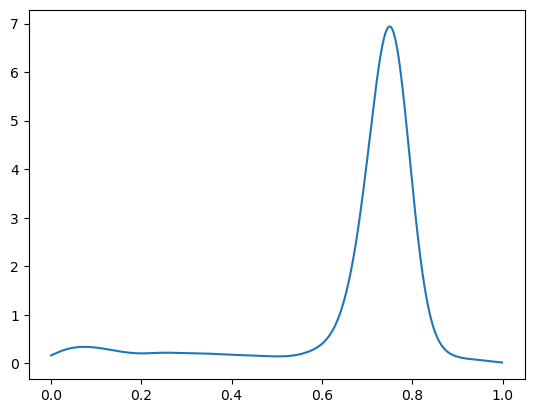

In [356]:
# 或许更好的方法是pm.Deterministic一个变量然后去算
delta_kde = gaussian_kde(trace_group.posterior['muw1'].values.flatten() - trace_group.posterior['muw2'].values.flatten())
x = np.arange(0, 1, 0.001)
plt.plot(x, delta_kde(x))